# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [0]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

**Collab setting**

In [2]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. uncomment this:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

--2019-05-07 05:53:14--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.67K  --.-KB/s    in 0s      

2019-05-07 05:53:14 (59.7 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [0]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)


In [0]:
data = data/255
np.savez("real.npz", Pictures=data.reshape(data.shape[0], 36*36*3))

In [5]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 3888)
(3143, 3888)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [0]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

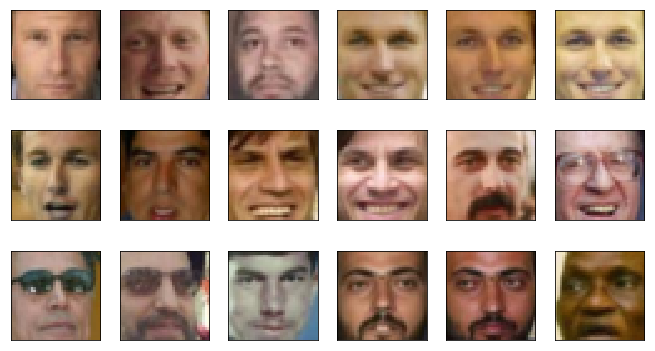

In [8]:
plot_gallery(X_train, image_h, image_w)

In [0]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [0]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W (***)
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

"""
(***)
"Understanding the difficulty of training deep feedforward neural networks" - Glorot, X. and Bengio, Y., using a uniform distribution.
Why not calling it Xavier? I spent some time figuring out this is the same as xavier uniform...
(***)
"""

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(                         
        nn.Linear(3*image_h*image_w, 500),
        nn.BatchNorm1d(500),
        nn.ReLU(True),
        nn.Linear(500, dimZ),
        nn.BatchNorm1d(dimZ)
                                )
    self.decoder = nn.Sequential(
        nn.Linear(dimZ, 500),
        nn.BatchNorm1d(500),
        nn.ReLU(True),
        nn.Linear(500, 3*image_h*image_w),
        nn.Sigmoid()
    )

    def initialize_params(layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0)

    self.apply(initialize_params)



  def forward(self, x):
    latent_code = self.encoder(x)
    reconstruction = self.decoder(latent_code)

    return reconstruction, latent_code

In [0]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

In [12]:
!pip install livelossplot

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

In [0]:

# Train your autoencoder
# Visualize progress in reconstruction and loss decay

def train_model(model, criterion, optimizer, num_epochs=10, path_to_save_models='models/autoenc/', tracked_image=None):
    try:
        os.makedirs(path_to_save_models)
    except Exception:
        pass
      
    liveloss = PlotLosses()
    model = model.to(device)
    image_track = []
    
    for epoch in range(num_epochs):
      logs = {}
      for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0

        for i, sample in enumerate(dataloaders[phase]):
          inputs = sample[0].to(device)

          outputs, code = model.forward(inputs)

          loss = criterion(outputs, inputs)

          if phase == 'train':
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()


          running_loss += loss.detach() * inputs.size(0)


        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        
        if phase == 'train':  
          rn = np.random.randint(0,inputs.shape[0])
          plt.subplot(1,2,1)
          plt.imshow(inputs[rn].view(image_h, image_w, 3).cpu().detach().numpy())
          plt.subplot(1,2,2)
          plt.imshow(outputs[rn].view(image_h, image_w, 3).cpu().detach().numpy())
          plt.title('Progress on train. Original and reconstructed')

        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'mse loss'] = epoch_loss.item()

      liveloss.update(logs)
      liveloss.draw()
      
      if tracked_image is not None:
        with torch.no_grad():
          image_track.append(model.forward(tracked_image.cuda())[0])

    return model, image_track

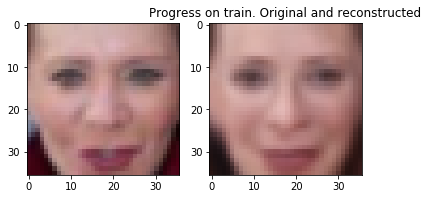

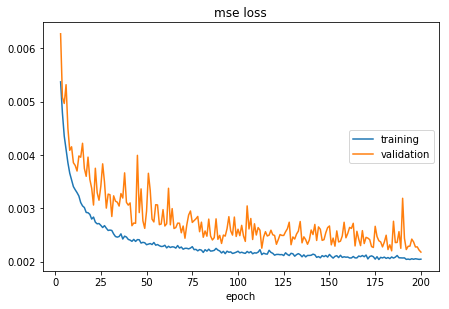

mse loss:
training   (min:    0.002, max:    0.012, cur:    0.002)
validation (min:    0.002, max:    0.008, cur:    0.002)


In [16]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
trained_model, image_progress = train_model(autoencoder, criterion, optimizer, num_epochs=200, path_to_save_models='models/autoenc1/', tracked_image=putin)

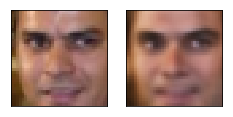

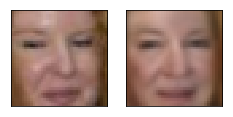

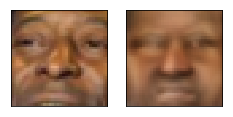

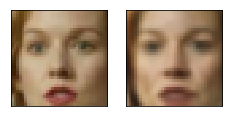

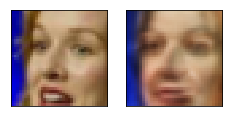

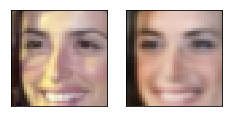

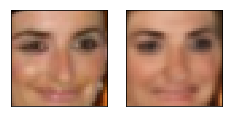

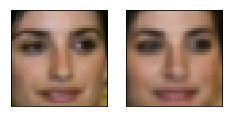

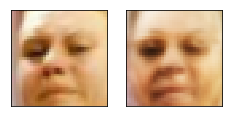

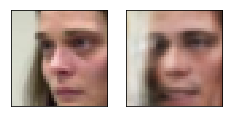

In [17]:
# Examine the reconstructions
for j, data in enumerate(val_loader, 0):
    inp = Variable(data[0].cuda())
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

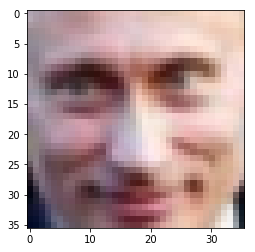

In [18]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
plt.imshow(putin.numpy().reshape((image_w, image_w, 3)))

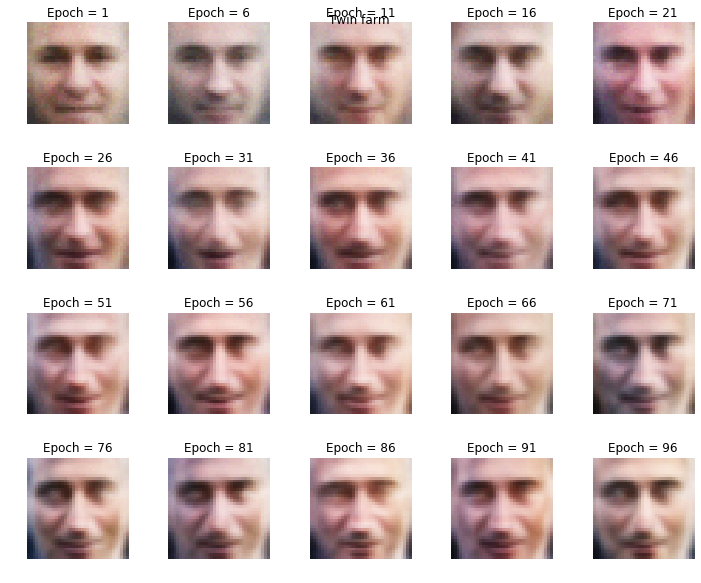

In [19]:
plt.figure(figsize=(10, 12))
plt.suptitle('Twin farm')
for i in range(len(image_progress[:20])):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(6, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3)) # it would be better to HIGHLIGHT that train should return image progress...
    plt.title('Epoch = {}'.format(i * 5 + 1))
    plt.axis('off')
plt.tight_layout()

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

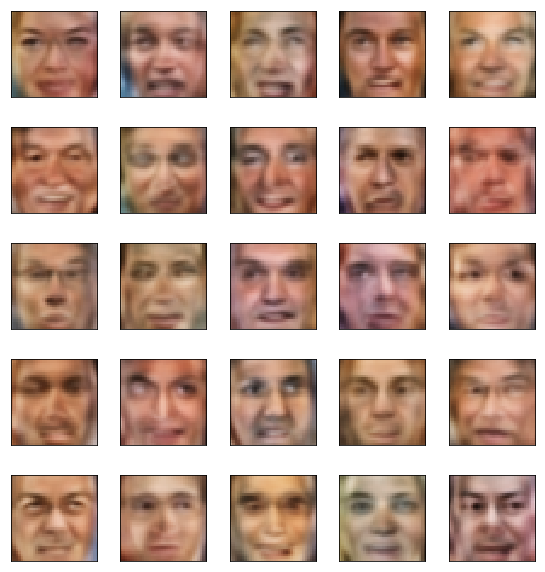

In [20]:
z = (np.random.randn(25, dimZ)*0.5).astype('float32')
output = autoencoder.decoder(Variable(torch.from_numpy(z)).cuda()).clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

**If distribution of all faces p(x) can be approximated nicely with finite dimensional distribution (for example it's definition area doesn't have white spaces) and we have a lot of data (it's not easy to say which quantity is enough though) --> yes. But of course we'll also get not naturally looking faces, so basically all possible faces we'll be included in the output. Emphasized restrictions are too complicated, so practically I think that it's not possible**

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [0]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
      super(VAE, self).__init__()

      #TODO
      
      self.encode_base = nn.Sequential(                         
          nn.Linear(3*image_h*image_w, 500),
          nn.BatchNorm1d(500),
          nn.ReLU(True)
      )
      
      self.mu_layer = nn.Linear(500, dimZ)
      self.logsigma_layer = nn.Linear(500, dimZ)
      
      self.decode_base = nn.Sequential(
          nn.Linear(dimZ, 500),
          nn.BatchNorm1d(500),
          nn.ReLU(True)
      )
      
      self.apost_mu_layer = nn.Linear(500, 3*image_h*image_w)
      self.apost_logsigma_layer = nn.Linear(500, 3*image_h*image_w)

      def initialize_params(layer):
        if type(layer) == nn.Linear:
          nn.init.xavier_uniform_(layer.weight, gain=0.1) # without it I got nans
          layer.bias.data.fill_(0)

      self.apply(initialize_params)
    
    
    def gaussian_sampler(self, mu, logsigma):
      if self.training:
        std = logsigma.exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)
      else:
        return mu

      
    def forward(self, x):
      latent_mu = self.mu_layer(self.encode_base(x))
      latent_logsigma = self.logsigma_layer(self.encode_base(x))
      z = self.gaussian_sampler(latent_mu, latent_logsigma)
      reconstruction_mu = self.apost_mu_layer(self.decode_base(z))
      reconstruction_logsigma = self.apost_logsigma_layer(self.decode_base(z))
      return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

**Because sigma cannot be negative**

In [0]:
import math

def KL_divergence(mu, logsigma):
  return torch.sum(-0.5 - logsigma + torch.mul(0.5, torch.pow(mu, 2)) + torch.mul(0.5, torch.pow(logsigma.exp(), 2)), dim=1).mean()

def log_likelihood(x, mu, logsigma):
  return torch.sum(torch.mul(-0.5, torch.log(torch.tensor(2 * math.pi))) - logsigma - torch.mul(0.5, torch.div(torch.pow(mu - x, 2), torch.pow(logsigma.exp(), 2))), dim=1).mean()

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
  L = -KL_divergence(mu_z, logsigma_z) + log_likelihood(x, mu_gen, logsigma_gen)
  return -L

And train the model:

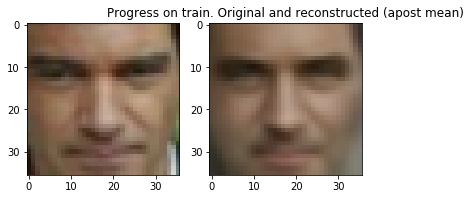

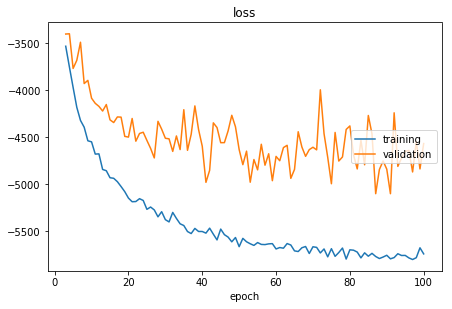

loss:
training   (min: -5803.218, max: 2844.295, cur: -5743.250)
validation (min: -5102.244, max: -2194.471, cur: -4568.372)


In [23]:
# train your autoencoder
# visualize progress in reconstruction and loss decay

vae = VAE().cuda()

# Use Adam optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.01)


def train_vae(model, optimizer, num_epochs=10, path_to_save_models='models/autoenc/', tracked_image=None):
    try:
        os.makedirs(path_to_save_models)
    except Exception:
        pass
      
    liveloss = PlotLosses()
    model = model.to(device)
    image_track = []
    
    for epoch in range(num_epochs):
      logs = {}
      for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0

        for i, sample in enumerate(dataloaders[phase]):
          inputs = sample[0].to(device)

          mu_apost, logsigma_apost, mu, logsigma = model.forward(inputs)
          loss = loss_vae(inputs, mu_apost, logsigma_apost, mu, logsigma)

          if phase == 'train':
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()


          running_loss += loss.detach() * inputs.size(0)


        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        
        if phase == 'train':  
          rn = np.random.randint(0,inputs.shape[0])
          plt.subplot(1,2,1)
          plt.imshow(inputs[rn].view(image_h, image_w, 3).cpu().detach().numpy())
          plt.subplot(1,2,2)
          plt.imshow(mu_apost[rn].view(image_h, image_w, 3).cpu().detach().numpy())
          plt.title('Progress on train. Original and reconstructed (apost mean)')

        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'loss'] = epoch_loss.item()

      liveloss.update(logs)
      liveloss.draw()
      
      if tracked_image is not None:
        with torch.no_grad():
          image_track.append(model.forward(tracked_image.cuda())[0])

    return model, image_track



for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
trained_model, image_progress = train_vae(vae, optimizer, num_epochs=100, path_to_save_models='models/vaenc/', tracked_image=putin)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


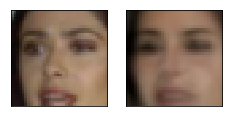

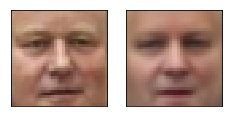

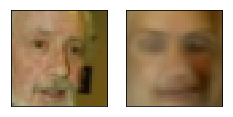

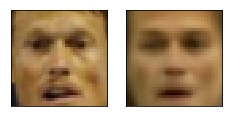

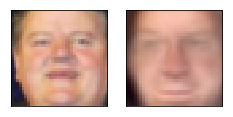

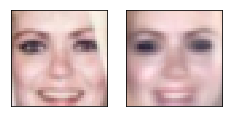

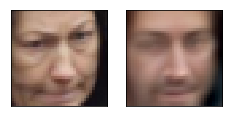

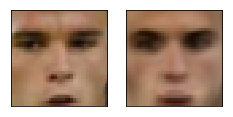

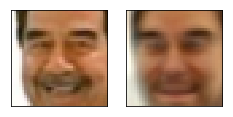

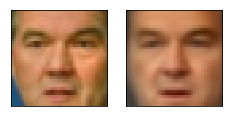

In [24]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = Variable(data[0].cuda())
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

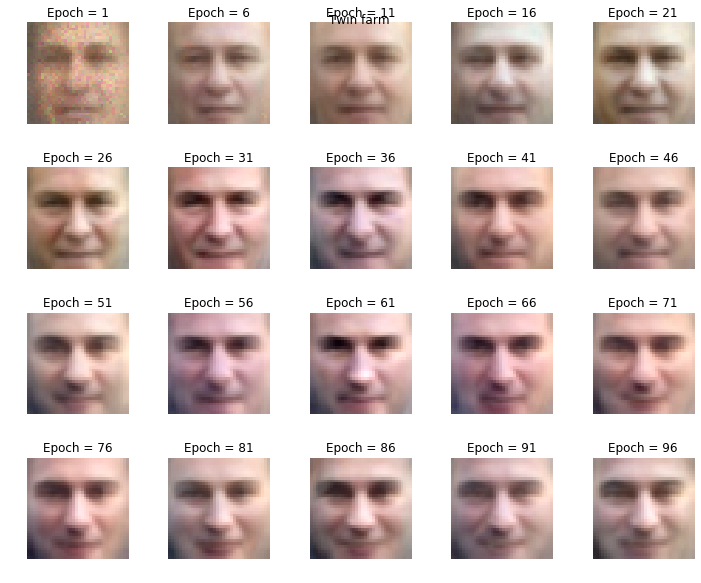

In [25]:
plt.figure(figsize=(10, 12))
plt.suptitle('Twin farm')
for i in range(len(image_progress[:20])):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(6, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3)) # it would be better to HIGHLIGHT that train should return image progress...
    plt.title('Epoch = {}'.format(i * 5 + 1))
    plt.axis('off')
plt.tight_layout()

And finally sample from VAE.

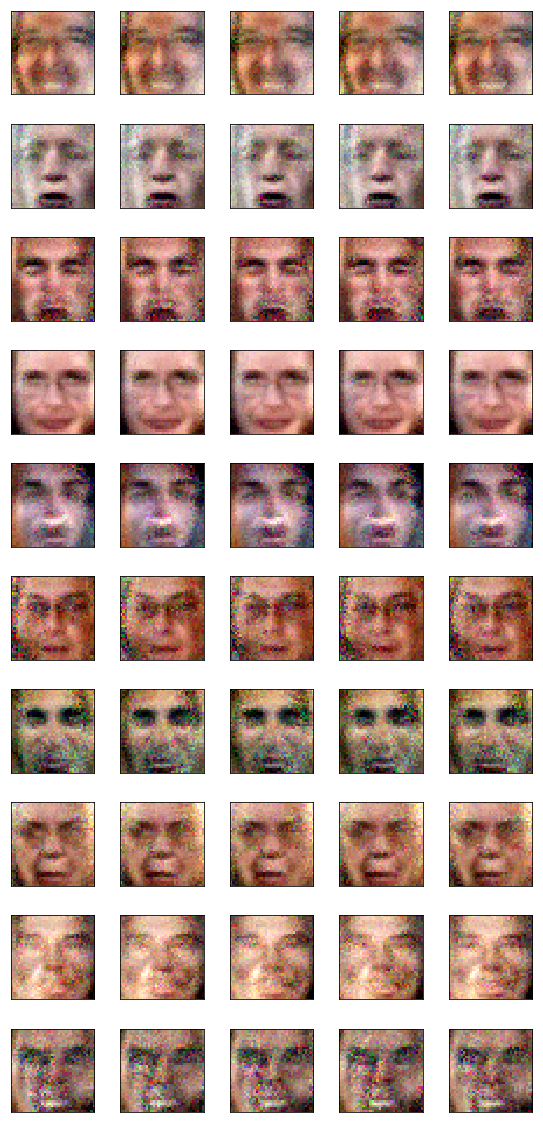

In [26]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
import torch.distributions as tdist

vae.eval()

n = tdist.Normal(torch.zeros(dimZ), torch.ones(dimZ))

z = n.sample((10,)).to(device)
mu = vae.apost_mu_layer(vae.decode_base(z))
logsigma = vae.apost_logsigma_layer(vae.decode_base(z))

pics = []

for idx in range(mu.shape[0]):
  N = tdist.Normal(mu[idx], logsigma.exp()[idx])
  bunch = N.sample((5,))
  for rec in bunch:
    pics.append(rec.cpu().numpy().clip(0,1))  
  
plot_gallery(pics, image_h, image_w, n_row=10, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

## If you are going to do part 4 (presicion-recall score): 

In [0]:
# using your model, generate face set with len = len(data)
n = tdist.Normal(torch.zeros(dimZ), torch.ones(dimZ))

z = n.sample((13143,)).to(device)
mu = vae.apost_mu_layer(vae.decode_base(z))
logsigma = vae.apost_logsigma_layer(vae.decode_base(z))

pics = []

for idx in range(mu.shape[0]):
  N = tdist.Normal(mu[idx], logsigma.exp()[idx])
  bunch = N.sample((1,))
  pics.append(bunch[0].cpu().numpy().clip(0,1))
  
answ = pics

## Save it ot npz

In [0]:
np.savez("vae.npz", Pictures=answ)

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

In [0]:
smiling_attr = attrs['Smiling'].values
smiling_attr = smiling_attr[:10000]
smiling_ranking = smiling_attr.argsort()
smiling_images = X_train[smiling_ranking[-10:]]
non_smiling_images = X_train[smiling_ranking[:10]]

In [0]:
def mood_changer(model, non_smiling_image, n = 10): # and probably gender (under construction)
    if model.__class__ == VAE:
        goodmood_images = model.mu_layer(model.encode_base(torch.tensor(smiling_images).cuda()))
        badmood_images = model.mu_layer(model.encode_base(torch.tensor(non_smiling_images).cuda()))
        badmood_image = model.mu_layer(model.encode_base(torch.tensor(non_smiling_image).cuda()))
    else:
        goodmood_images = model.encoder(torch.tensor(smiling_images).cuda())
        badmood_images = model.encoder(torch.tensor(non_smiling_images).cuda())
        badmood_image = model.encoder(torch.tensor(non_smiling_image).cuda())

    goodmood_center = goodmood_images.mean(dim=0, keepdim=True)
    badmood_center = badmood_images.mean(dim=0, keepdim=True)
    sixties_road = goodmood_center - badmood_center

    images = []
    for i in range(n):
        planning_to_move_towards_happiness = badmood_image + sixties_road * i / (n - 1)

        if model.__class__ == VAE:
            moved_towards_happiness = model.apost_mu_layer(model.decode_base(planning_to_move_towards_happiness))
        else:
            moved_towards_happiness = model.decoder(planning_to_move_towards_happiness)
        moved_towards_happiness = moved_towards_happiness.clamp(0, 1).detach().cpu()
        images.append(moved_towards_happiness)
    images = torch.cat(images)

    plot_gallery(images, image_h, image_w, n_row=1, n_col=n)

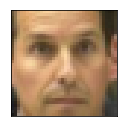

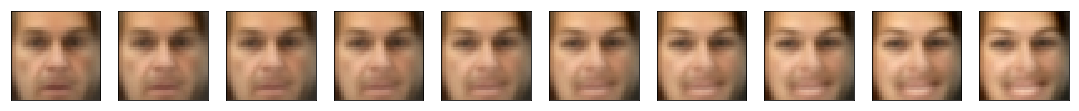

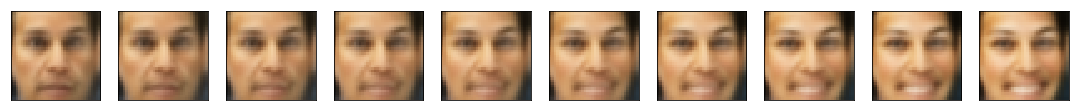

In [40]:
n = 666
non_smiling_image = X_train[[smiling_ranking[n]]]
plot_gallery(non_smiling_image, image_h, image_w, n_row=1, n_col=1)

mood_changer(vae, X_train[[smiling_ranking[n]]])
mood_changer(autoencoder, X_train[[smiling_ranking[n]]])

In [0]:
from google.colab import files
files.download('vae.npz') 

In [41]:
from google.colab import files
files.download('real.npz') 

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 59800, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil